# Preliminaries
<a href="https://colab.research.google.com/github/cwf2/dices-mta/blob/main/Mother%20speech.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pandas as pd
import requests
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
from IPython.display import HTML

# Data
#### remote data    
Pre-prepared data saved in the GitHub repo

In [2]:
local_path = 'data'
remote_path = 'https://github.com/cwf2/dices-mta/raw/main/data/'
data_files = ['merged.csv', 'mother-child.csv', 'mother_diction.csv']

if not os.path.exists(local_path):
    os.mkdir(local_path)
for filename in data_files:
    if not os.path.exists(os.path.join(local_path, filename)):
        print(f'downloading {filename}')
        res = requests.get(remote_path + filename, json={"download":""})
        if not res.ok:
            res.raise_for_status()
        with open(os.path.join(local_path, filename), 'wb') as f:
            f.write(res.content)

### token table

In [3]:
tokens_file = os.path.join(local_path, 'merged.csv')
tokens = pd.read_csv(tokens_file, dtype=str)
display(tokens)

,speech_id,lang,author,work,urn,l_fi,l_la,nlines,spkr,addr,...,mood_cltk,tense_cltk,voice_cltk,aspect,person_cltk,number_cltk,case_cltk,gender_cltk,degree_cltk,verbform_cltk
0,1,greek,Homer,Iliad,urn:cts:greekLit:tlg0012.tlg001.perseus-grc2,1.17,1.21,5,Chryses,"Agamemnon,Greeks",...,NaN,NaN,NaN,NaN,NaN,plural,nominative,masculine,NaN,NaN
1,1,greek,Homer,Iliad,urn:cts:greekLit:tlg0012.tlg001.perseus-grc2,1.17,1.21,5,Chryses,"Agamemnon,Greeks",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,greek,Homer,Iliad,urn:cts:greekLit:tlg0012.tlg001.perseus-grc2,1.17,1.21,5,Chryses,"Agamemnon,Greeks",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,greek,Homer,Iliad,urn:cts:greekLit:tlg0012.tlg001.perseus-grc2,1.17,1.21,5,Chryses,"Agamemnon,Greeks",...,NaN,NaN,NaN,NaN,NaN,plural,nominative,masculine,NaN,NaN
4,1,greek,Homer,Iliad,urn:cts:greekLit:tlg0012.tlg001.perseus-grc2,1.17,1.21,5,Chryses,"Agamemnon,Greeks",...,NaN,NaN,NaN,NaN,NaN,plural,nominative,masculine,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376180,4694,latin,Prudentius,Psychomachia,urn:cts:latinLit:stoa0238.stoa002.perseus-lat2,1.799,1.822,24,Fides,Virtues,...,NaN,NaN,NaN,NaN,NaN,plural,dative,feminine,NaN,NaN
376181,4694,latin,Prudentius,Psychomachia,urn:cts:latinLit:stoa0238.stoa002.perseus-lat2,1.799,1.822,24,Fides,Virtues,...,NaN,NaN,NaN,NaN,NaN,singular,accusative,feminine,NaN,NaN
376182,4694,latin,Prudentius,Psychomachia,urn:cts:latinLit:stoa0238.stoa002.perseus-lat2,1.799,1.822,24,Fides,Virtues,...,subjunctive,present,active,imperfective,third,singular,NaN,NaN,NaN,finite
376183,4694,latin,Prudentius,Psychomachia,urn:cts:latinLit:stoa0238.stoa002.perseus-lat2,1.799,1.822,24,Fides,Virtues,...,NaN,NaN,passive,perfective,NaN,singular,nominative,feminine,NaN,participle


### List of mother-child pairs

In [4]:
mothers_file = os.path.join(local_path, 'mother-child.csv')
mothers = pd.read_csv(mothers_file, sep='\t')
display(mothers)

,spkr,addr
0,Alcimede,Jason
1,Aphrodite,Eros
2,Chalciope,Argus (son of Phrixus)
3,Chalciope,sons of Phrixus
4,Chariclo,Tiresias
5,Leto,Apollo
6,Ceres,Proserpina
7,Cybele,Ceres
8,Venus,Cupid
9,Venus,Cupids


### Identify mother speeches

This custom function checks the speaker and addressee instances of a speech against the list of mother-child pairs.

In [5]:
def motherValidation(rec):
    '''check whether any speaker-addressee combo is in the mother-child list'''
    valid_keys = list(mothers.spkr + ':' + mothers.addr)

    if rec['spkr'] is np.NaN:
        return False
    if rec['addr'] is np.NaN:
        return False
    
    for spkr in str(rec['spkr']).split(','):
        for addr in str(rec['addr']).split(','):
            key = f'{spkr}:{addr}'
            if key in valid_keys:
                return True

    return False

#### Add `mother` column

Add boolean mother flag to the token table

In [6]:
tokens['mother'] = tokens.apply(motherValidation, axis=1)

#### How many mother speeches?

In [7]:
tokens.groupby('speech_id').agg(speech_id=('speech_id', 'first'), mother=('mother', 'first')).groupby('mother').agg(count=('speech_id', 'count'))

,count
mother,
False,4037
True,83


## Hand-selected feature sets

In [8]:
class_file = os.path.join('data', 'mother_diction.csv')
lemma_class = pd.read_csv(class_file)

In [9]:
lem_dict = dict()

for label in lemma_class.label.unique():
    if not pd.isna(label):
        lem_dict[label] = lemma_class.loc[lemma_class.label == label, 'lemma'].values
        print(label, ':', sep="")
        print(*lem_dict[label], sep=" ")
        print()

family:
'nate altricus altrix avus auus coniunx coniux filius frater Frater fraterque gemina genetrix genitor genus infans mater matr maternus matrisque nao nascor Nata Nate natus no parens pario partus pater paternus patriosque patrius patruum pietas proavum progeo proles puer soror spons αἶμαι ἄλοχος ἀμήτωρ Γάμος γάμος γαστήρ γεῖνος γενέθλη γενέθλα γενετήρ γενέτης γενέτη γένος γλάγος γονεύς γόνος Εἰλείθυια ἐννεάκυκλος θάλος θυγάτηρ θύγατρα κασιγνήτης κόρη κόρος κούρη κοῦρε κοῦρος λοχεία λοχέια λοχεύω λωχεύω μητερός μήτηρ μῆτηρ μητρυιά μογόστοκος μόγοστοκος νύμφη Νύμφη νυμφίε νυμφίον νυμφίος ὁμογάστριον Παῖδες Παῖδος παῖς πατήρ πατή πατρόφονος πατρώιος πατρῷος προπάτωρ Τέκνον τέκνον τέκος τίκτω τοκετοῖος τοκεύς τοκῆος τόκος υἱός υἷος φίλη φίλος ὠδίν ὠδίνω ὠδίς

pers_1s:
ego egomet egomo me Me mears Mecus Meitus Mene meus miho γώ ἐγὠ ἐγώ ἐγὼ ἐγῶ ἔγω ἐμοῖ ἐμοῖο ἐμὀν ἐμός μ

pers_1p:
Nobis Nosne noster nosteriquus nostr Nostra nostraeue nostrane Nostrasne nostrive nostrus ἧμας ἦμεις ἡμεῖ

#### Add additional classification columns

In [10]:
# add columns for the hand-marked features
for tag in ['family', 'pers_1s', 'pers_2s']:
    tokens[tag] = tokens['lemma_spacy'].isin(lem_dict[tag]) | tokens['lemma_cltk'].isin(lem_dict[tag])

tokens['interrog'] = tokens['lemma_spacy'].isin(lem_dict['interrog'])

# combine first and second person singular personal pronouns and possessives
tokens['pers'] = (tokens['pers_1s'] | tokens['pers_2s'])

# imperatives
tokens['imper'] = (tokens['mood_cltk'] == 'imperative') | (tokens['mood_spacy'] == 'Imp')

In [11]:
display(tokens)

,speech_id,lang,author,work,urn,l_fi,l_la,nlines,spkr,addr,...,gender_cltk,degree_cltk,verbform_cltk,mother,family,pers_1s,pers_2s,interrog,pers,imper
0,1,greek,Homer,Iliad,urn:cts:greekLit:tlg0012.tlg001.perseus-grc2,1.17,1.21,5,Chryses,"Agamemnon,Greeks",...,masculine,NaN,NaN,False,False,False,False,False,False,False
1,1,greek,Homer,Iliad,urn:cts:greekLit:tlg0012.tlg001.perseus-grc2,1.17,1.21,5,Chryses,"Agamemnon,Greeks",...,NaN,NaN,NaN,False,False,False,False,False,False,False
2,1,greek,Homer,Iliad,urn:cts:greekLit:tlg0012.tlg001.perseus-grc2,1.17,1.21,5,Chryses,"Agamemnon,Greeks",...,NaN,NaN,NaN,False,False,False,False,False,False,False
3,1,greek,Homer,Iliad,urn:cts:greekLit:tlg0012.tlg001.perseus-grc2,1.17,1.21,5,Chryses,"Agamemnon,Greeks",...,masculine,NaN,NaN,False,False,False,False,False,False,False
4,1,greek,Homer,Iliad,urn:cts:greekLit:tlg0012.tlg001.perseus-grc2,1.17,1.21,5,Chryses,"Agamemnon,Greeks",...,masculine,NaN,NaN,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376180,4694,latin,Prudentius,Psychomachia,urn:cts:latinLit:stoa0238.stoa002.perseus-lat2,1.799,1.822,24,Fides,Virtues,...,feminine,NaN,NaN,False,False,False,False,False,False,False
376181,4694,latin,Prudentius,Psychomachia,urn:cts:latinLit:stoa0238.stoa002.perseus-lat2,1.799,1.822,24,Fides,Virtues,...,feminine,NaN,NaN,False,False,False,False,False,False,False
376182,4694,latin,Prudentius,Psychomachia,urn:cts:latinLit:stoa0238.stoa002.perseus-lat2,1.799,1.822,24,Fides,Virtues,...,NaN,NaN,finite,False,False,False,False,False,False,False
376183,4694,latin,Prudentius,Psychomachia,urn:cts:latinLit:stoa0238.stoa002.perseus-lat2,1.799,1.822,24,Fides,Virtues,...,feminine,NaN,participle,False,False,False,False,False,False,False


# Analysis

### log odds

Use log odds to rank all lemmas by their pertinence to the "mother" class

In [12]:
def rankFeatures(col, top=None):
    # freq in non-mother speeches
    freq_others = tokens.loc[~tokens['mother']].groupby(col).size().reset_index(name='count')
    freq_others['freq'] = freq_others['count'].div(freq_others['count'].sum())
    
    # freq in mother speeches
    freq_mother = tokens.loc[tokens['mother']].groupby(col).size().reset_index(name='count')
    freq_mother['freq'] = freq_mother['count'].div(freq_mother['count'].sum())

    # merge the two tables, so we have mother, non-mother freqs for each feature
    x = freq_others.merge(freq_mother, on=col, suffixes=('_others', '_mother'))

    # calculate log odds
    x['lod'] = np.log((x['freq_mother'] + 1) / (x['freq_others'] + 1))
    x = x.sort_values('lod', ascending=False)

    # optionally select just the top ranked results
    if top is not None:
        x = x[:top]

    # map the hand-picked feature classes onto the results where applicable
    x = x.merge(lemma_class.rename(columns={'lemma':col}), on=col, how='left') 
    
    return(x)

In [13]:
rankFeatures('lemma_spacy', 25)

,lemma_spacy,count_others,freq_others,count_mother,freq_mother,lod,label
0,?,2119,0.005755,116,0.014547,0.008704,interrog
1,tu,1917,0.005206,89,0.011161,0.005907,pers_2s
2,τέκνον,110,0.000299,33,0.004138,0.003831,family
3,hic,2141,0.005815,73,0.009155,0.003315,NaN
4,σύ,3247,0.008818,92,0.011537,0.002692,pers_2s
5,ego,1967,0.005342,63,0.007901,0.002542,pers_1s
6,mater,181,0.000492,24,0.003010,0.002514,family
7,quis,674,0.001830,33,0.004138,0.002301,NaN
8,ἐμός,833,0.002262,35,0.004389,0.002120,pers_1s
9,que,6526,0.017724,157,0.019689,0.001929,NaN


In [14]:
rankFeatures('lemma_cltk', 25)

,lemma_cltk,count_others,freq_others,count_mother,freq_mother,lod,label
0,?,2111,0.005911,115,0.014929,0.008925,interrog
1,tu,1827,0.005116,91,0.011814,0.006641,pers_2s
2,τέκνον,109,0.000305,33,0.004284,0.003970,family
3,hic,2208,0.006183,76,0.009866,0.003654,NaN
4,σύ,3346,0.009369,96,0.012463,0.003060,pers_2s
5,qui,2931,0.008207,85,0.011035,0.002800,NaN
6,nascor,375,0.001050,29,0.003765,0.002708,family
7,mater,193,0.000540,25,0.003245,0.002700,family
8,ego,1994,0.005584,63,0.008179,0.002577,pers_1s
9,ἐμός,829,0.002321,34,0.004414,0.002086,pers_1s


## rolling window of 5 lines

In [15]:
results = []
for label, group in tokens.groupby('speech_id'):
    df = group.groupby('line_id', sort=False).agg(
        author = ('author', 'first'),
        work = ('work', 'first'),
        l_fi = ('l_fi', 'first'),
        l_la = ('l_la', 'first'),
        spkr = ('spkr', 'first'),
        addr = ('addr', 'first'),
        mother = ('mother', 'first'),
        tokens = ('token_spacy', 'count'),
        imper = ('imper', 'sum'),
        family = ('family', 'sum'),
        pers = ('pers', 'sum'),
        interrog = ('interrog', 'sum'),
    )
    results.append(
        pd.DataFrame(dict(
            speech_id = label,
            author = df['author'],
            work = df['work'],
            l_fi = df['l_fi'],
            l_la = df['l_la'],
            spkr = df['spkr'],
            addr = df['addr'],
            mother = df['mother'],
            lines = df['tokens'].rolling(window=5, min_periods=1, center=True).count(),
            tokens = df['tokens'].rolling(window=5, min_periods=1, center=True).sum(),
            family = df['family'].rolling(window=5, min_periods=1, center=True).sum(),
            imper = df['imper'].rolling(window=5, min_periods=1, center=True).sum(),
            pers = df['pers'].rolling(window=5, min_periods=1, center=True).sum(),
            interrog = df['interrog'].rolling(window=5, min_periods=1, center=True).sum(),
        ))
    )
results = pd.concat(results)
results['imper_norm'] = results['imper'].div(results['tokens'])
results['family_norm'] = results['family'].div(results['tokens'])
results['pers_norm'] = results['pers'].div(results['tokens'])
results['interrog_norm'] = results['interrog'].div(results['tokens'])

results['comp'] = results['imper'] + results['family'] + results['pers'] + results['interrog']
results['comp_norm'] = results['comp'].div(results['tokens'])

### Top speeches by max composite score

In [16]:
x = results.groupby('speech_id', sort=False).agg(
    author = ('author', 'first'),
    work = ('work', 'first'),
    l_fi = ('l_fi', 'first'),
    l_la = ('l_la', 'first'),
    spkr = ('spkr', 'first'),
    addr = ('addr', 'first'),
    mother = ('mother', 'first'),
    lines = ('tokens', 'count'),
    tokens = ('tokens', 'sum'),
    comp_avg = ('comp', 'mean'),
    comp_sum = ('comp', 'sum'),
    comp_max = ('comp', 'max'),
)
x['loc'] = x['l_fi'] + '-' + x['l_la']
x['comp_norm'] = x['comp_sum'] / x['tokens']
x = x.sort_values('comp_max', ascending=False)
x.query('comp_max>12')

,author,work,l_fi,l_la,spkr,addr,mother,lines,tokens,comp_avg,comp_sum,comp_max,loc,comp_norm
speech_id,,,,,,,,,,,,,,
1758,Virgil,Aeneid,9.481,9.497,mother of Euryalus (son of Opheltes),"Euryalus (son of Opheltes),Jupiter,Rutulians",True,17,622.0,9.058824,154.0,18.0,9.481-9.497,0.247588
3669,Nonnus,Dionysiaca,48.832,48.847,Artemis,Aura (nymph),False,16,512.0,8.500000,136.0,17.0,48.832-48.847,0.265625
3216,Statius,Thebaid,10.690,10.718,Creon,Menoeceus,False,29,1095.0,6.931034,201.0,16.0,10.690-10.718,0.183562
3375,Nonnus,Dionysiaca,10.196,10.216,Dionysus,Ampelus,False,21,733.0,8.047619,169.0,16.0,10.196-10.216,0.230559
3374,Nonnus,Dionysiaca,10.129,10.136,Semele,Semele,False,8,223.0,9.250000,74.0,15.0,10.129-10.136,0.331839
4546,Eudocia,Homerocentones,1927,1939,Jesus,God (Christian),False,6,206.0,11.333333,68.0,15.0,1927-1939,0.330097
19,Homer,Iliad,1.293,1.303,Achilles,Agamemnon,False,11,422.0,8.272727,91.0,14.0,1.293-1.303,0.215640
582,Homer,Iliad,22.82,22.89,Hecuba,Hector,True,8,275.0,10.750000,86.0,14.0,22.82-22.89,0.312727
4318,Ps.-Oppian,Cynegetica,3.220,3.233,donkey mother,"donkey child,donkey mother",False,14,430.0,8.071429,113.0,14.0,3.220-3.233,0.262791


### max scores of mother speeches

In [17]:
x.loc[x['mother']]

,author,work,l_fi,l_la,spkr,addr,mother,lines,tokens,comp_avg,comp_sum,comp_max,loc,comp_norm
speech_id,,,,,,,,,,,,,,
1758,Virgil,Aeneid,9.481,9.497,mother of Euryalus (son of Opheltes),"Euryalus (son of Opheltes),Jupiter,Rutulians",True,17,622.0,9.058824,154.0,18.0,9.481-9.497,0.247588
582,Homer,Iliad,22.82,22.89,Hecuba,Hector,True,8,275.0,10.750000,86.0,14.0,22.82-22.89,0.312727
3501,Nonnus,Dionysiaca,31.136,31.190,Iris-Nyx,Hypnus,True,55,1706.0,4.200000,231.0,12.0,31.136-31.190,0.135404
3137,Statius,Thebaid,7.497,7.527,Jocasta,"Argive warriors,Polynices",True,31,1165.0,6.290323,195.0,11.0,7.497-7.527,0.167382
2305,Ovid,Metamorphoses,13.494,13.532,Hecuba,Polyxena,True,36,1320.0,5.027778,181.0,11.0,13.494-13.532,0.137121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1538,Virgil,Aeneid,1.335,1.370,Venus-huntress,"Achates,Aeneas",True,36,1138.0,0.583333,21.0,2.0,1.335-1.370,0.018453
2089,Ovid,Metamorphoses,6.621,6.622,Procne,Itys,True,2,32.0,1.000000,2.0,1.0,6.621-6.622,0.062500
2724,Silius,Punica,2.645,2.645,"Eurymedon (brother of Lycormas),mother of Lyco...",Lycormas,True,1,8.0,1.000000,1.0,1.0,2.645-2.645,0.125000


### distribution of scores

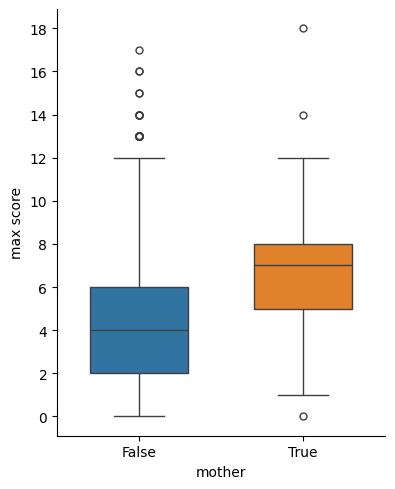

In [18]:
from matplotlib.ticker import MultipleLocator
g = sns.catplot(
    data = x, 
    y = 'comp_max', 
    x = 'mother', 
    hue = 'mother', 
    kind = 'box',
    width = 0.6,
    legend = False
)
g.ax.set_ylabel("max score")
g.ax.yaxis.set_major_locator(MultipleLocator(2))
g.fig.set_figwidth(4)

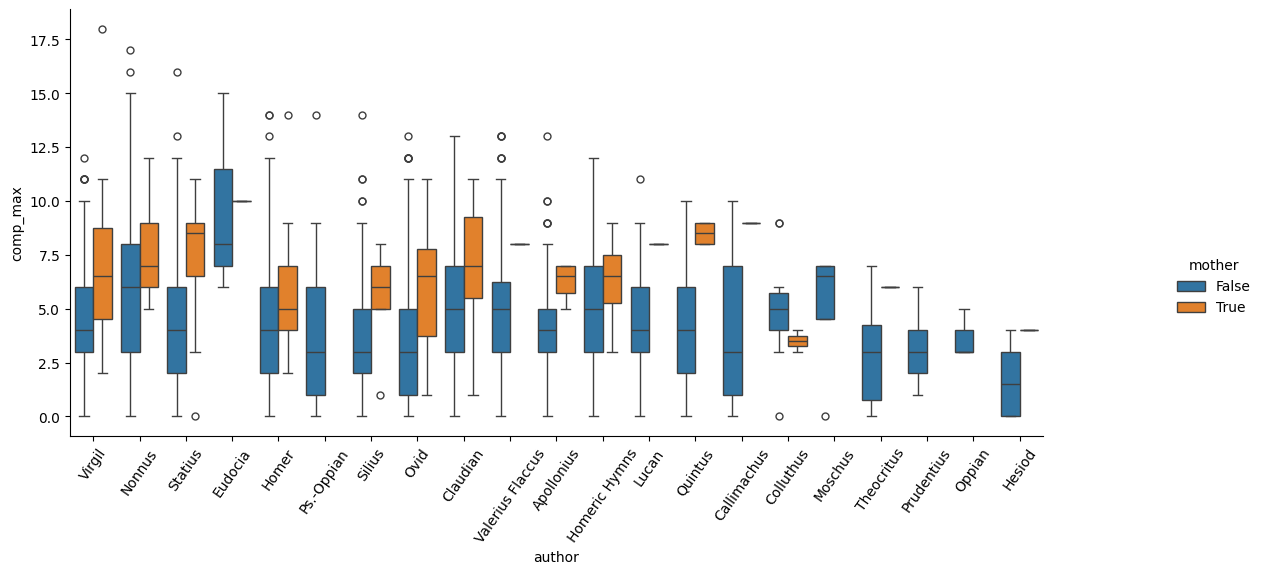

In [19]:
g = sns.catplot(data=x, y='comp_max', x='author', hue='mother', kind='box', dodge=True)
g.fig.set_figwidth(14)
g.ax.tick_params(axis="x", rotation=55)

## plot individual speeches

In [20]:
def linePlot(speech_id):
    mask = results['speech_id']==speech_id
    ys = results.loc[mask, 'comp']

    _, l_fi = ys.index.values[0].rsplit(':', 1)
    _, l_la = ys.index.values[-1].rsplit(':', 1)
    author = results.loc[mask, 'author'].iloc[0]
    work = results.loc[mask, 'work'].iloc[0]
    title = f"{author} {work} {l_fi}-{l_la}"

    if '.' in l_fi:
        _, l_fi = l_fi.rsplit('.', 1)
    l_fi = int(l_fi)
    xs = np.arange(l_fi, l_fi+len(ys))

    avg = results['comp'].median()
    
    fig, ax = plt.subplots(figsize=(8,5))
    ax.plot(xs, ys)
    ax.axhline(avg, color=sns.light_palette('#79C')[3], ls='--')
    ax.set_ylabel('rolling composite score')
    ax.set_xlabel('line')
    ax.yaxis.set_major_locator(MultipleLocator(2))
    ax.set_ylim((0,20))
    ax.set_title(title)
    plt.close(fig)
    return fig

def stackPlot(speech_id):
    mask = results['speech_id']==speech_id
    cols = ['family', 'imper', 'pers', 'interrog']
    df = results.loc[mask, cols]
    _, l_fi = df.index.values[0].rsplit(':', 1)
    _, l_la = df.index.values[-1].rsplit(':', 1)
    author = results.loc[mask, 'author'].iloc[0]
    work = results.loc[mask, 'work'].iloc[0]
    title = f"{author} {work} {l_fi}-{l_la}"

    if '.' in l_fi:
        _, l_fi = l_fi.rsplit('.', 1)
    l_fi = int(l_fi)
    xs = np.arange(l_fi, l_fi+len(df))
    df['line'] = xs

    avg = results['comp'].median()
    
    ax = df.plot.area(x='line', linewidth=0, figsize=(8,5))
    ax.axhline(avg, color='white', ls='--')
    ax.yaxis.set_major_locator(MultipleLocator(2))
    ax.set_ylim((0,20))
    ax.set_title(title)
    ax.set_ylabel('rolling score (5-line window)')
    ax.set_xlabel('line')
    fig = ax.figure
    plt.close(fig)
    return fig

def hl(col):
    return lambda string: f'<span style="font-weight:bold;color:{col}">{string}</span>'

def highlight(speech_id):
    mask = tokens['speech_id']==speech_id
    foo = pd.DataFrame(dict(
        line_id = tokens.loc[mask, 'line_id'],
        token = tokens.loc[mask, 'token_spacy'],
    ))
    foo.loc[tokens.loc[mask, 'family'], 'token'] = foo.loc[tokens.loc[mask, 'family'], 'token'].apply(hl('blue'))
    foo.loc[tokens.loc[mask, 'imper'], 'token'] = foo.loc[tokens.loc[mask, 'imper'], 'token'].apply(hl('orange'))
    foo.loc[tokens.loc[mask, 'pers'], 'token'] = foo.loc[tokens.loc[mask, 'pers'], 'token'].apply(hl('green'))
    foo.loc[tokens.loc[mask, 'interrog'], 'token'] = foo.loc[tokens.loc[mask, 'interrog'], 'token'].apply(hl('red'))
    
    html = '<table>' + '\n'.join(foo
        .groupby("line_id", sort=False)
        .agg(
            loc = ("line_id", lambda s: '<td>' + s.iloc[0].rsplit(':', 1)[1] + '</td>'),
            tokens = ("token", lambda s: '<td>' + ' '.join(s) + '<td>'),)
        .apply(lambda row: f'<tr>{row["loc"]}{row["tokens"]}</tr>', axis=1)
    ) + '</table>'
    
    return HTML(html)

def plotAndText(speech_id):
    fig = stackPlot(speech_id)
    html = highlight(speech_id)
    display(fig, html)

## Examples for the article

#### Artemis to Aura

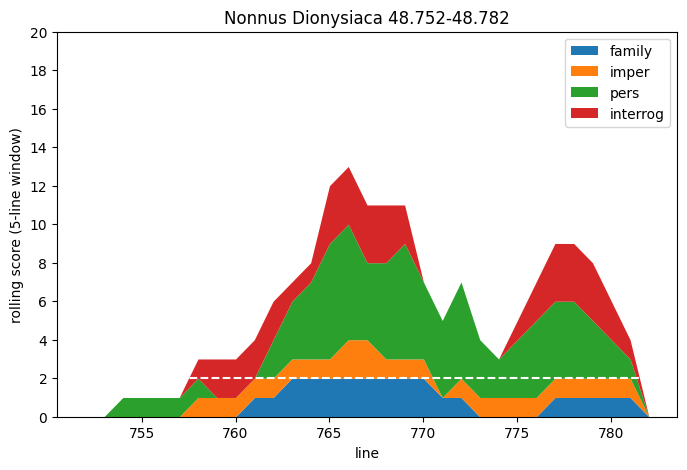

48.752
48.753
48.754
48.755
48.756
48.757
48.758
48.759
48.760
48.761
48.762


In [30]:
plotAndText('3665')

#### Euryalus' mother

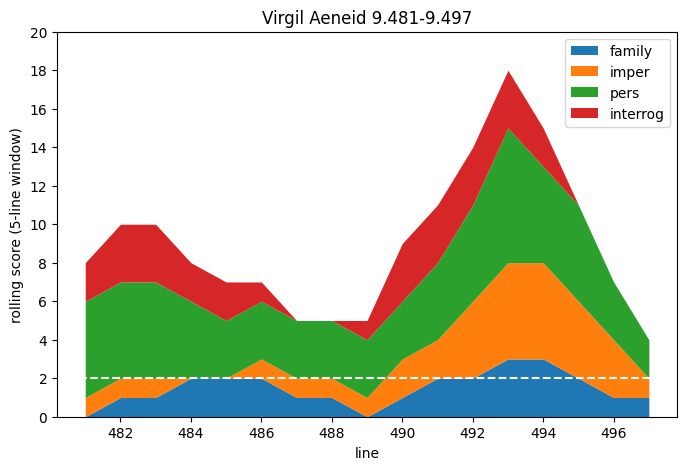

9.481
9.482
9.483
9.484
9.485
9.486
9.487
9.488
9.489
9.490
9.491


In [22]:
plotAndText('1758')

#### Creon to Menoeceus

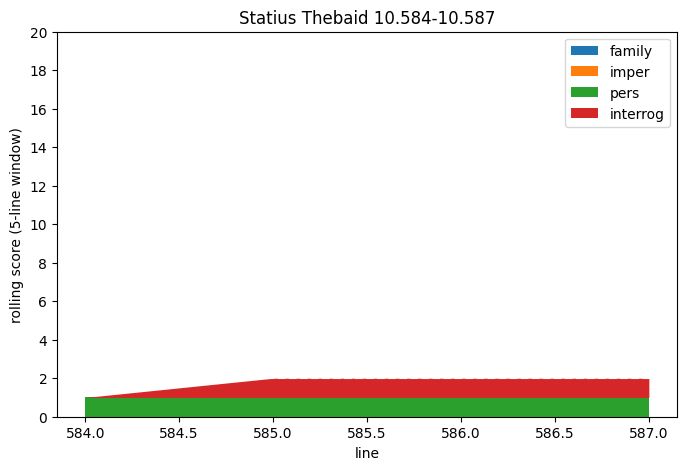

10.584
10.585
10.586
10.587


In [23]:
plotAndText('3210')

#### Hecuba to Hector

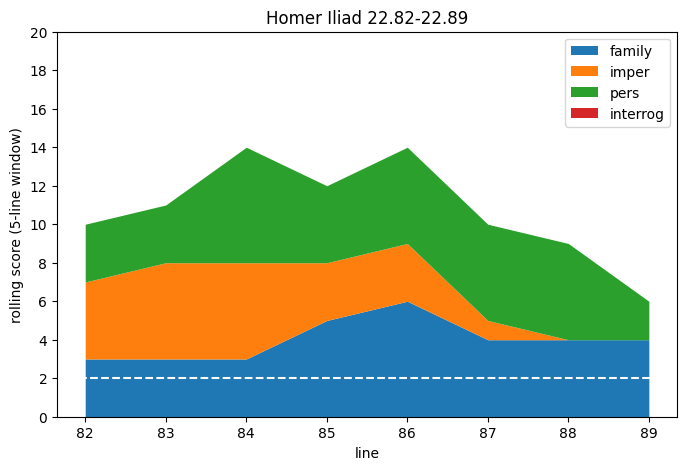

22.82
22.83
22.84
22.85
22.86
22.87
22.88
22.89


In [24]:
plotAndText('582')

#### Mary to Jesus

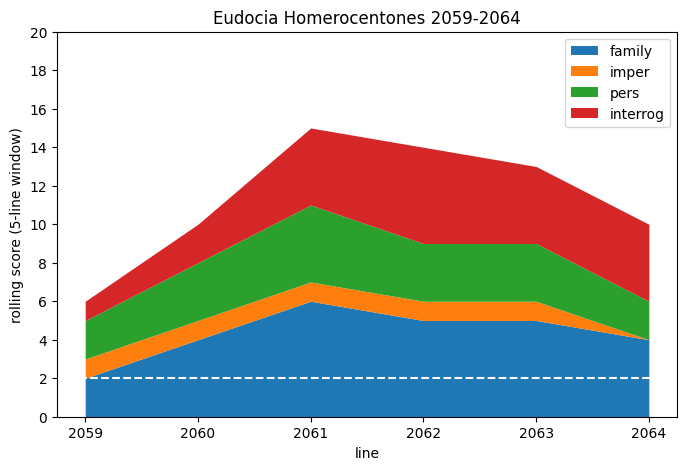

2059
2060
2061
2062
2063
2064


In [25]:
plotAndText('4546')

#### Mother donkey

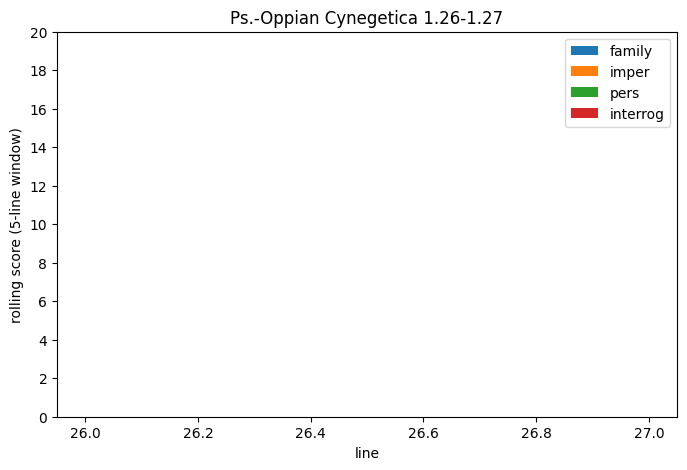

1.26
1.27


In [26]:
plotAndText('4310')

#### Iris-Nyx

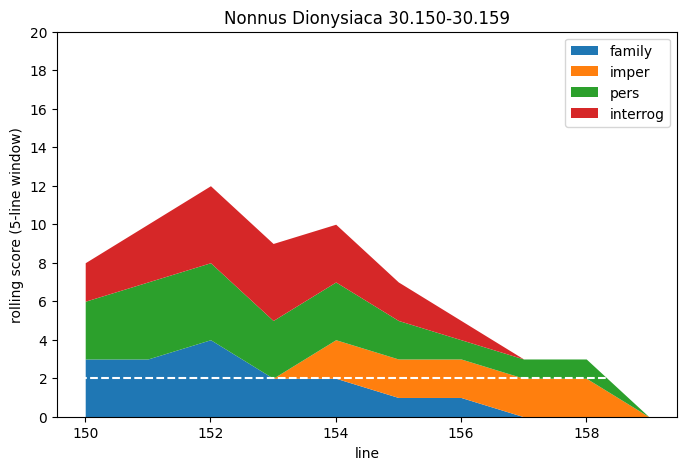

30.150
30.151
30.152
30.153
30.154
30.155
30.156
30.157
30.158
30.159


In [27]:
plotAndText('3494')

In [28]:
tokens.to_clipboard()

In [29]:
results.groupby('speech_id', sort=False).agg(
    author = ('author', 'first'),
    work = ('work', 'first'),
    l_fi = ('l_fi', 'first'),
    l_la = ('l_la', 'first'),
    spkr = ('spkr', 'first'),
    addr = ('addr', 'first'),
    mother = ('mother', 'first'),
    lines = ('tokens', 'count'),
    tokens = ('tokens', 'sum'),
    comp_avg = ('comp', 'mean'),
    comp_sum = ('comp', 'sum'),
    comp_max = ('comp', 'max'),
).sort_values(["comp_max", "comp_avg"], ascending=False).query("comp_max>12")

,author,work,l_fi,l_la,spkr,addr,mother,lines,tokens,comp_avg,comp_sum,comp_max
speech_id,,,,,,,,,,,,
1758,Virgil,Aeneid,9.481,9.497,mother of Euryalus (son of Opheltes),"Euryalus (son of Opheltes),Jupiter,Rutulians",True,17,622.0,9.058824,154.0,18.0
3669,Nonnus,Dionysiaca,48.832,48.847,Artemis,Aura (nymph),False,16,512.0,8.500000,136.0,17.0
3375,Nonnus,Dionysiaca,10.196,10.216,Dionysus,Ampelus,False,21,733.0,8.047619,169.0,16.0
3216,Statius,Thebaid,10.690,10.718,Creon,Menoeceus,False,29,1095.0,6.931034,201.0,16.0
4546,Eudocia,Homerocentones,1927,1939,Jesus,God (Christian),False,6,206.0,11.333333,68.0,15.0
3374,Nonnus,Dionysiaca,10.129,10.136,Semele,Semele,False,8,223.0,9.250000,74.0,15.0
582,Homer,Iliad,22.82,22.89,Hecuba,Hector,True,8,275.0,10.750000,86.0,14.0
3670,Nonnus,Dionysiaca,48.858,48.864,Artemis,Aura (nymph),False,7,202.0,10.000000,70.0,14.0
19,Homer,Iliad,1.293,1.303,Achilles,Agamemnon,False,11,422.0,8.272727,91.0,14.0
